In [12]:
from time import strptime

import numpy as np
import pandas as pd

## Load Data

In [13]:
hierarchy_f = open("./hierarchy.csv", "r")
load_f = open("./load.csv", "r")
temp_f = open("./temperature.csv", "r")
relative_humidity_f = open("./relative_humidity.csv", "r")

hierarchy = pd.read_csv(hierarchy_f)
raw_load = pd.read_csv(load_f)
raw_temp = pd.read_csv(temp_f)
raw_humidity = pd.read_csv(relative_humidity_f)

## Processing Data

We want an year-hourly representation of all data points.

### Load

In [14]:
def init_load_df(raw_load):
    dates = raw_load.date.unique()

    row_inds = []
    for d in dates:
        d = d.replace("/", "-")
        for i in range(1, 25):
            row_inds.append("{}-{}".format(d, i))

    col_inds = raw_load.meter_id.unique()
    col_inds = ["meter_{}".format(i) for i in col_inds]
    
    load_df = pd.DataFrame(index=row_inds, columns=col_inds)
    return load_df

load_df = init_load_df(raw_load)

In [15]:
def to_list(r):
    return list(r[2:])

def flatten(r):
    return [i for l in r for i in l]

load_l = raw_load.iloc[:, :2]
load_l["hourly"] = raw_load.apply(to_list, axis=1)
hourly_load = load_l.groupby("meter_id")["hourly"].apply(list)
hourly_load = hourly_load.apply(flatten)

# Drops incomplete meters
hourly_load = hourly_load[hourly_load.apply(len) == 61344]

# Fills into dataframe
for ind, meter in hourly_load.items():
    load_df.loc[:, "meter_" + str(ind)] = meter
    
# Drops empty meters
load_df = load_df.dropna(axis=1, how="all")

/tmp/ipykernel_9750/2436949608.py:17: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  load_df.loc[:, "meter_" + str(ind)] = meter


### Temperature & Humidity

In [16]:
def convert_time(row):
    date = row.date
    d = date[:2]
    m = str(strptime(date[2:5],'%b').tm_mon)
    if len(m) < 2:
        m = "0" + m
    y = date[5:]
    h = row.hr
    
    ind = "{}-{}-{}-{}".format(m, d, y, h)
    return ind
    
temp = raw_temp.set_index(raw_temp.apply(convert_time, axis=1))
temp = temp.drop(columns=["date", "hr"])
temp

,t_ws1,t_ws2,t_ws3,t_ws4,t_ws5,t_ws6,t_ws7,t_ws8,t_ws9,t_ws10,...,t_ws19,t_ws20,t_ws21,t_ws22,t_ws23,t_ws24,t_ws25,t_ws26,t_ws27,t_ws28
01-01-2005-1,43,46,40,47,48,46,44,52,45,42,...,39,50,43,45,50,47,41,47,47,45
01-01-2005-2,41,46,38,46,48,45,51,50,42,41,...,41,49,43,46,47,47,45,47,47,45
01-01-2005-3,40,46,37,45,45,45,49,48,43,40,...,43,50,41,45,45,46,45,46,46,43
01-01-2005-4,39,46,37,47,48,48,45,50,42,39,...,43,49,41,43,45,44,45,47,47,44
01-01-2005-5,38,46,37,44,48,49,43,50,42,38,...,43,49,39,43,43,45,45,47,46,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-31-2011-20,44,45,43,46,48,51,49,48,43,49,...,43,53,51,43,46,56,45,46,48,44
12-31-2011-21,41,37,39,49,45,47,46,46,37,46,...,39,47,49,41,45,55,41,45,46,44
12-31-2011-22,40,37,37,47,43,47,44,45,37,44,...,37,48,46,41,44,50,41,45,44,42
12-31-2011-23,38,37,35,47,43,48,42,43,37,43,...,36,47,44,37,42,48,37,40,43,38


In [17]:
humidity = raw_humidity.set_index(raw_humidity.apply(convert_time, axis=1))
humidity = humidity.drop(columns=["date", "hr"])
humidity

,rh_ws1,rh_ws2,rh_ws3,rh_ws4,rh_ws5,rh_ws6,rh_ws7,rh_ws8,rh_ws9,rh_ws10,...,rh_ws19,rh_ws20,rh_ws21,rh_ws22,rh_ws23,rh_ws24,rh_ws25,rh_ws26,rh_ws27,rh_ws28
01-01-2005-1,99,93,93,90,87,93,93,82,67,90,...,93,93,93,81,83,97,87,83,86,86
01-01-2005-2,76,93,97,89,87,97,80,88,67,100,...,87,97,87,82,86,93,81,83,86,86
01-01-2005-3,79,93,93,90,93,97,83,87,63,76,...,87,96,93,81,93,96,76,86,89,93
01-01-2005-4,79,93,93,90,87,89,90,82,63,76,...,87,97,93,81,93,100,81,86,90,93
01-01-2005-5,79,93,96,93,87,90,93,82,59,76,...,87,97,93,87,97,97,81,86,89,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-31-2011-20,78,76,68,68,71,61,86,76,66,66,...,81,74,54,71,89,53,71,78,63,76
12-31-2011-21,86,87,79,59,87,71,79,82,81,71,...,87,83,59,76,90,55,81,81,68,73
12-31-2011-22,86,87,86,63,87,71,89,81,81,80,...,93,83,66,76,89,71,81,81,73,79
12-31-2011-23,91,87,89,66,87,71,89,81,81,81,...,93,86,72,87,96,71,93,89,74,86


## Merged DF

In [18]:
data_df = load_df.join(humidity).join(temp)

In [19]:
meter_cols = [c for c in data_df.columns if c[:5] == "meter"]
non_meter_cols = [c for c in data_df.columns if c[:5] != "meter"]
data_df = data_df[non_meter_cols + meter_cols]
data_df.dropna(inplace=True)

Including aggregate statistics

In [20]:
def append_hierarchical_means(df, hierarchy):
    df = df.copy()
    for mid_level, meters in hierarchy.groupby("mid_level")["meter_id"]:
        cols = ["meter_{}".format(m) for m in meters]
        cols = list(set(cols).intersection(set(df.columns)))
        if len(cols) == 0:
            continue
        df[mid_level] = df[cols].sum(axis=1)
    
    for aggregate, mid_levels in hierarchy.groupby("aggregate")["mid_level"]:
        mid_levels = mid_levels.unique()        
        mid_levels = list(set(mid_levels).intersection(set(df.columns)))
        df[aggregate] = df[mid_levels].sum(axis=1)
    return df

data_df_wm = append_hierarchical_means(data_df, hierarchy)

Use min-max normalization on data

In [24]:
def minmax_norm(df):
    return (df-df.min())/(df.max()-df.min())

norm_data_df = minmax_norm(data_df_wm)

## Adjacency Matrix

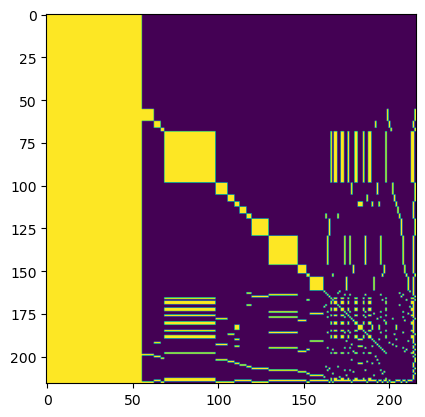

In [21]:
def set_adj_hierarchy(adj_mat, df, hierarchy):
    for mid_level, data in hierarchy.groupby("mid_level"):
        aggregate = data["aggregate"].unique()
        assert(len(aggregate) == 1)
        aggregate = aggregate[0]
        meters = data.meter_id

        cols = ["meter_{}".format(m) for m in meters]
        cols = list(set(cols).intersection(set(df.columns)))
        if len(cols) == 0:
            continue
        
        inds = [df.columns.get_loc(c) for c in cols]
        agg_ind = df.columns.get_loc(aggregate)
        mid_ind = df.columns.get_loc(mid_level)

        for i in inds:
            # Meters depend on other meters within clusters
            adj_mat[i][inds] = 1
            # Meters also depend on aggregate stats
            adj_mat[i][agg_ind] = 1
            adj_mat[i][mid_ind] = 1
            adj_mat[mid_ind][inds] = 1
            adj_mat[agg_ind][inds] = 1

        # Aggregate stats depend on each other
        adj_mat[mid_ind][agg_ind] = 1
        adj_mat[agg_ind][mid_ind] = 1

        
def get_adj_mat(data_df_wm):
    n_var = data_df_wm.columns.shape[0]
    adj_mat = np.zeros((n_var, n_var))

    # Meters depend on weather stations
    # Note that we don't set the other direction
    adj_mat[56:, :56] = 1

    # Weather is probably correlated
    adj_mat[:56, :56] = 1

    set_adj_hierarchy(adj_mat, data_df_wm, hierarchy)
    plt.imshow(adj_mat)
    return adj_mat

adj_mat = get_adj_mat(data_df_wm)

## Export

In [25]:
import pickle

dataset = {
    "df": norm_data_df,
    "adj_mat": adj_mat
}

with open("gefcom2017_processed.pkl", "wb") as f:
    pickle.dump(dataset, f)